[View in Colaboratory](https://colab.research.google.com/github/liannesr/Lab-5-Machine-Learning/blob/master/Lianne_Sanchez_Lab_5_Using_Categorical_Features.ipynb)

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Imports and Pandas Options
We import the libraries we are using and set some panda options.

In [0]:
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# This line increasing the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have one digit for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Data Set
As in the last lab we use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets) 

### Load and randomizing the data
Load the data using the column names from [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile). When using SGD (stochastic graident descent) for training it is important that **each batch is a random sample of the data** so that the gradient computed is representative.  While there appears to be no order to this data set, it is always good practice to shuffle the data to be in a random order.


In [0]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


# Load in the data from a CSV file that is comma seperated.
car_data = pd.read_csv('https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
                        sep=',', names=cols, header=None, encoding='latin-1')

# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

### Converting Missing Numerical Values to the Column Mean

As you hopefully found in the last exercise, a good option for replacing missing entries (NaN) is to replace them by the column mean.  We do that here.

In [0]:
car_data['price'] = pd.to_numeric(car_data['price'], errors='coerce')
car_data['horsepower'] = pd.to_numeric(car_data['horsepower'], errors='coerce')
car_data['peak-rpm'] = pd.to_numeric(car_data['peak-rpm'], errors='coerce')
car_data['city-mpg'] = pd.to_numeric(car_data['city-mpg'], errors='coerce')
car_data['highway-mpg'] = pd.to_numeric(car_data['highway-mpg'], errors='coerce')

# Replace nan by the mean storing the solution in the same table (`inplace')
car_data.fillna(car_data.mean(), inplace=True)

### Build Your First Tensor Flow Model

We now build a model to predict `price`, which will be our label (sometimes also called a target) using `horsepower` as our input feature. To train our model, we'll use the [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) interface provided by the TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API. This API takes care of a lot of the low-level model plumbing, and exposes convenient methods for performing model training, evaluation, and inference.

###Prepare Features
As our learning models get more sophisticated we will want to do some computation on the features and even generate new features from the existing features. We will see examples of this in later labs.  For now this method will just make a copy of a portion of the dataframe.

In [0]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  return processed_features

###Generate the Training Examples
We simple call `prepare_features` on the `car_data` dataframe.

In [0]:
training_examples = prepare_features(car_data)

###Setting Up the Feature Columns for TensorFlow

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this and future exercises:

* **Numerical Data**: Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical.

* **Categorical Data**: Data that is textual such as `make` or 'fuel-type`.

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**. Feature columns store only a description of the feature data; they do not contain the feature data itself.

For now, we will just use numerical features.  Later you wll learn how to use categorical data.

In [0]:
NUMERICAL_FEATURES = ["horsepower"]

def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(feature)
              for feature in NUMERICAL_FEATURES])

### Input Function
To import our data into a LinearRegressor, we need to define an input function, which instructs TensorFlow how to preprocess the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our Pandas feature data into a dictionary of NumPy arrays. We can then use the TensorFlow Dataset API to construct a dataset object from our data, and then break our data into batches of batch_size, to be repeated for the specified number of epochs (num_epochs).

When the default value of num_epochs=None is passed to repeat(), the input data will be repeated indefinitely.

Next, if shuffle is set to True, we'll shuffle the data so that it's passed to the model randomly during training. The buffer_size argument specifies the size of the dataset from which shuffle will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

**NOTE:** We'll continue to use this same input function in later exercises. For more
detailed documentation of input functions and the `Dataset` API, see the [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training..
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Define Input Functions Using the Training Data

We can now use a labda function to create an input function to use when training the model, and one to use when evaluating the model's loss on the training data.

In [0]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"  

# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    num_epochs=1, shuffle=False)

###Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

**NOTE:** To be safe, we also apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail. 

In [0]:
def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    A linear regressor created with the given parameters
  """
  
  optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=optimizer
  )  
  return linear_regressor

## Computing the Loss
For now we are using root mean squared error (RMSE) for our loss since that is the appropriate loss to use for linear regression.  However, to keep the procedure to train the model very generic, we will use a method compute loss that can be tailored to other types of problems. For this lab, our implementation will be to return the RMSE.


In [0]:
def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

##Learning Curve

Another important tool is a graph often called a **learning curve** that shows the loss being minimized on the y-axis and the training steps (time) on the x-axis.  Looking at the learning curve will help you understand if you have set the `learning_rate` too high or too low, how many `steps` you need to train and other things that we'll explore later.  

Next we define a method to plot the learning curve given a list of training losses that will be recorded at regular intervals during training.

In [0]:
def plot_learning_curve(training_losses):
  """ Plot the learning curve
  
  Args:
    training_loses: a list of losses to plot
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses)

###Visualizing Our Model Via a Calibration Plot

When we just use a single input feature, we can visualize the data and the learned model very well with **scater plot**.  In order to help understand higher-dimensional models, a **calibration plot** is very useful. A calibration plot is similar to a scatter plot of the data except this can be used for any linear model since it just plots the target with respec to the predictions. Observe that a model with an RMSE of 0 would have all points on the line target = prediction.  For points that are under the line, we are overpredicting and points over the line we are underpredicting.  This method shows the line target = prediction to help visualize how well the model is doing.

Observe that unlike in the scatter plot where the points are fixed and the model (as viewed as a line changes), in the callibration plot the x-coordinate of the points change as the model is trained.

In [0]:
def calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])

### Function to train a model

We provide a method that trains a linear model using any set of features that breaks the learning up into 10 periods, and shows the learning curve and calibration plot after training the model.

In [0]:
# Function to train any linear model using a calibration plot to help visualize
# the final model

def train_model(linear_regressor, features, labels, steps, batch_size):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train
    features: The input features to use
    label: the labels
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained regressor
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn and predict_training_input_fn
  training_input_fn = lambda: input_fn(features, labels, batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(features, labels, num_epochs=1,
                                               shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training losses to generate the training curve
  print("Training model...")
  training_losses = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps
    _ = linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)

    # Use the predict method to compute the predictions from the current model
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
   
    # Compute the loss between the predictions and the correct labels, append
    # the loss to the list of losses used to generate the learning curve after
    # training is complete and print the current loss
    loss = compute_loss(predictions, labels)
    training_losses.append(loss) 
    print("  Loss after period %02d : %0.3f" % (period, loss))
      
  # Now that training is done print the final loss    
  print("Final Loss (RMSE) on the training data: %0.3f" % loss) 
  
  # Generate a figure with the learning curve on the left and either a scatter
  # plot or calibration plot (when more than 2 input features) on the right
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses)
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
  plt.title("Calibration Plot")
  calibration_plot(predictions, labels)
   
  return linear_regressor

In [0]:
# Perform log scaling
def log_scale(series):
  return series.apply(lambda x:math.log(x+1.0))

# Linearly rescales to the range [0, 1]
def linear_scale(series):
  scale = 1.0 * (series.max() - series.min())
  return series.apply(lambda x: (x - series.min()) / scale)

### Using Categorical Features

We now modify `construct_feature_columns` to use both categorical and numerical columns. To get you started we'll show an example of how to set up each of the kind of features you will be using.  Then you can add in additional features corresponding to the features that you'd like to use when training your model.

####Categorical Feauture Columns with known values.

When the values are known you can simply use code like below.  If you would view the weights index 0 will be the first key provided, index 1, the next key,.....  See [`categorical_column_with_vocabulary_list`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list) for more details.

```
  drive_wheels = tf.feature_column.categorical_column_with_vocabulary_list(
      keys="drive-wheels", vocabulary_list=["fwd", "rwd", "4wd"])
```

####Categorical Feature Columns without known values

Since you don't always know the possible values you can instead assign an index to each possible value via hashing.

```
  make = tf.feature_column.categorical_column_with_hash_bucket(
     key="make", hash_bucket_size=100)
```
See [`categorical_column_with_hash_buckets`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_hash_bucket) for more details.

####Numerical Columns directly used as a real number
As we have seen in the past lab, we can directly use a real-valued column as a feature
```
   price = tf.contrib.layers.real_valued_column("price") 
```


In [0]:
def construct_feature_columns():
  """Construct TensorFlow feature columns.
  
  Returns:
    A set of feature columns.
  """
  drive_wheels = tf.feature_column.categorical_column_with_vocabulary_list(
      key="drive-wheels", vocabulary_list=["fwd", "rwd", "4wd"])
  make = tf.feature_column.categorical_column_with_hash_bucket(
      key="make", hash_bucket_size=100)
  price = tf.contrib.layers.real_valued_column("price")
  return [drive_wheels, make, price]

## Prepare Features

As you have seen it is very important to ensure your features are roughly in the same range.  Since the categorical features are all encoded as 0 or 1, as a basic implementation of `prepare_features`,  linear scaling from 0 to 1 is applied to all the numerical feautres.  Feel free to modify this to use alternate scaling.

We do not scale the labels since that is not necessary for learning and doing so would require that we provide the inverse transformation to the predicted value.

In [0]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  for feature in NUMERICAL_FEATURES:
    if (feature != LABEL):
      processed_features[feature] = linear_scale(processed_features[feature])
  return processed_features

# Generate the training examples
training_examples = prepare_features(car_data)

Let's now train a model with these few features.

Training model...
  Loss after period 00 : 17.693
  Loss after period 01 : 17.801
  Loss after period 02 : 17.693
  Loss after period 03 : 17.801
  Loss after period 04 : 17.693
  Loss after period 05 : 17.801
  Loss after period 06 : 20.946
  Loss after period 07 : 17.801
  Loss after period 08 : 17.693
  Loss after period 09 : 20.669
Final Loss (RMSE) on the training data: 20.669


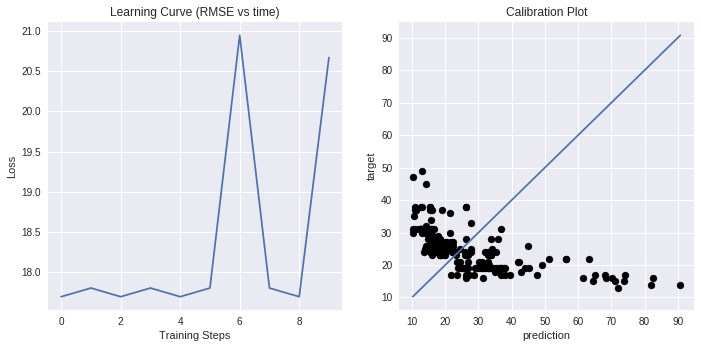

In [22]:
NUMERICAL_FEATURES = ["price"]
CATEGORICAL_FEATURES = ["drive-wheels", "make"]
LABEL = "city-mpg"

# LEARNING_RATE = 0.01
# BATCH_SIZE = 50
# STEPS = 750

LEARNING_RATE = 0.0001
BATCH_SIZE = 50
STEPS = 750
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor,
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES],
    training_examples[LABEL],
    batch_size=BATCH_SIZE, steps=STEPS)

###Look at the weights###

In [23]:
# Illustrating how to see all the weights in the model
print(linear_regressor.get_variable_names())

for feature in ["price"]:
  if feature != LABEL:
    w = linear_regressor.get_variable_value('linear/linear_model/' + feature + '/weights')[0]
    print("weight for", feature, "is", w)
for feature in ["make", "drive-wheels"]:
  w = linear_regressor.get_variable_value('linear/linear_model/' + feature + '/weights')
  print("more significant weights for", feature, "are:")
  for weight, i in zip(w, range(len(w))):
    if (weight > 1 or weight < -1):
        print("   index", i, "of weight", weight)  
print("bias:",  linear_regressor.get_variable_value("linear/linear_model/bias_weights"))

['global_step', 'linear/linear_model/bias_weights', 'linear/linear_model/drive-wheels/weights', 'linear/linear_model/make/weights', 'linear/linear_model/price/weights']
weight for price is [0.00199992]
more significant weights for make are:
more significant weights for drive-wheels are:
bias: [7.631515e-05]


Recall that the keys for `drive-wheels` are `keys=["fwd", "rwd", "4wd"])`.  If you want to be able to correlate the makes with the keys then you'd wnat to use `sparse_column_with_keys`.

## Exercise: Train a Model with Categorical Features (5 points)

Train the best model you can to predict `city-mpg` using any features with whatever feature processing you'd like to include. Make use of all that you've done in the previous labs. The codebox below gives you an example.  Right now it just trains the same model as above.  You should modify `construct_feature_columns` to include the features you'd like to use, and of course modify the learning rate and number of steps to train the model.  Don't forget to generate new training data if you add additional features. You can duplicate this code box in order to show the results for more than one model. Please submit the lab with the model you trained that had the lowest loss and also one or two others that you feel are interesting.

Training model...
  Loss after period 00 : 6.737
  Loss after period 01 : 4.855
  Loss after period 02 : 4.448
  Loss after period 03 : 4.283
  Loss after period 04 : 4.145
  Loss after period 05 : 4.135
  Loss after period 06 : 4.077
  Loss after period 07 : 3.989
  Loss after period 08 : 4.076
  Loss after period 09 : 4.050
Final Loss (RMSE) on the training data: 4.050


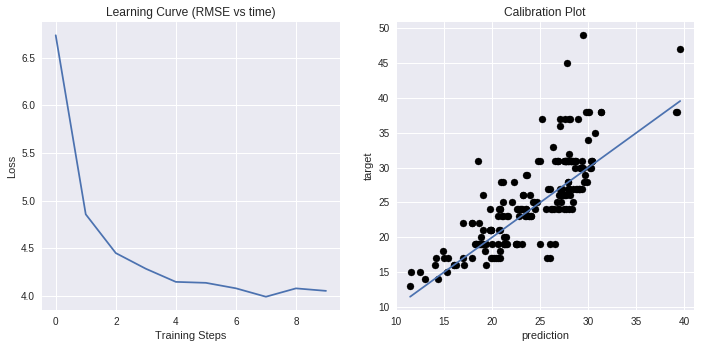

In [24]:
# Redefining NUMERICAL_FEATURES and CATEGORICAL FEATURES just for the
# convenience of having them here.

NUMERICAL_FEATURES = ["horsepower", "highway-mpg", "price",
                      "peak-rpm", "compression-ratio"]
CATEGORICAL_FEATURES = ["fuel-system", "make", "fuel-type",
                        "body-style", "drive-wheels"]
LABEL = "city-mpg"

def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns
  """
  drive_wheels = tf.contrib.layers.sparse_column_with_keys(
      column_name="drive-wheels", keys=["fwd", "rwd", "4wd"])
  make = tf.contrib.layers.sparse_column_with_hash_bucket(
      "make", hash_bucket_size=100)
  price = tf.contrib.layers.real_valued_column("price")
  return [drive_wheels, make, price]

# Generate the training examples
training_examples = prepare_features(car_data)

LEARNING_RATE = 0.1
BATCH_SIZE = 50
STEPS = 350
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor,
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 9.717
  Loss after period 01 : 5.044
  Loss after period 02 : 4.520
  Loss after period 03 : 4.105
  Loss after period 04 : 3.900
  Loss after period 05 : 3.684
  Loss after period 06 : 3.566
  Loss after period 07 : 3.462
  Loss after period 08 : 3.380
  Loss after period 09 : 3.321
Final Loss (RMSE) on the training data: 3.321


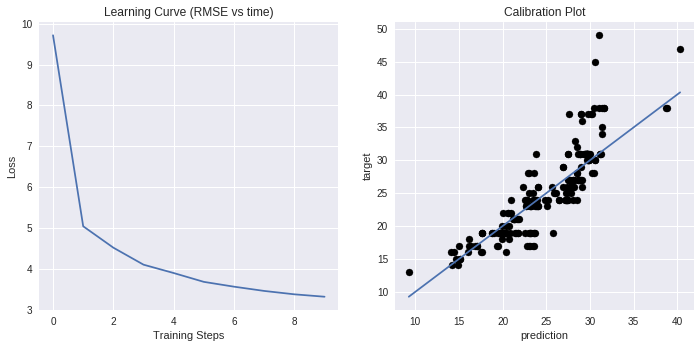

In [63]:
# Redefining NUMERICAL_FEATURES and CATEGORICAL FEATURES just for the
# convenience of having them here.

NUMERICAL_FEATURES = ["horsepower", "highway-mpg", "price",
                      "peak-rpm", "compression-ratio"]
CATEGORICAL_FEATURES = ["fuel-system", "make", "fuel-type",
                        "body-style", "drive-wheels"]
LABEL = "city-mpg"

def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns
  """
  drive_wheels = tf.contrib.layers.sparse_column_with_keys(
      column_name="drive-wheels", keys=["fwd", "rwd", "4wd"])
  make = tf.contrib.layers.sparse_column_with_hash_bucket(
      "make", hash_bucket_size=100)
  price = tf.contrib.layers.real_valued_column("price")
  horsepower = tf.contrib.layers.real_valued_column("horsepower")
  return [drive_wheels, make, price, horsepower]

# Generate the training examples
training_examples = prepare_features(car_data)

LEARNING_RATE = 0.07
BATCH_SIZE = 50
STEPS = 400
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor,
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 3.934
  Loss after period 01 : 2.648
  Loss after period 02 : 1.957
  Loss after period 03 : 1.602
  Loss after period 04 : 1.353
  Loss after period 05 : 1.248
  Loss after period 06 : 1.206
  Loss after period 07 : 1.229
  Loss after period 08 : 1.207
  Loss after period 09 : 1.196
Final Loss (RMSE) on the training data: 1.196


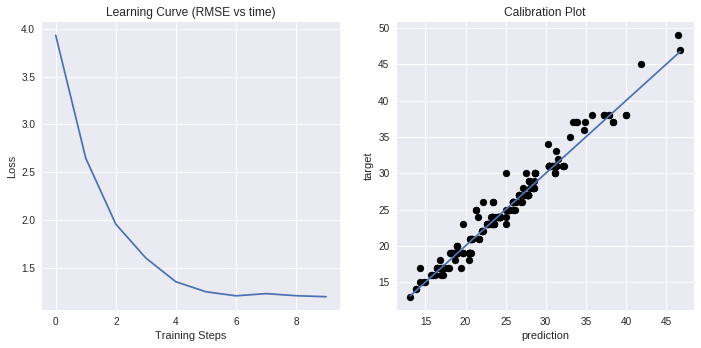

In [62]:
# Redefining NUMERICAL_FEATURES and CATEGORICAL FEATURES just for the
# convenience of having them here.

NUMERICAL_FEATURES = ["horsepower", "highway-mpg", "price",
                      "peak-rpm", "compression-ratio"]
CATEGORICAL_FEATURES = ["fuel-system", "make", "fuel-type",
                        "body-style", "drive-wheels"]
LABEL = "city-mpg"

def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns
  """
  drive_wheels = tf.contrib.layers.sparse_column_with_keys(
      column_name="drive-wheels", keys=["fwd", "rwd", "4wd"])
  make = tf.contrib.layers.sparse_column_with_hash_bucket(
      "make", hash_bucket_size=100)
  price = tf.contrib.layers.real_valued_column("price")
  #horsepower = tf.contrib.layers.real_valued_column("horsepower")
  highway_mpg = tf.contrib.layers.real_valued_column("highway-mpg")
  return [drive_wheels, make, price,highway_mpg]

# Generate the training examples
training_examples = prepare_features(car_data)

LEARNING_RATE = 0.05
BATCH_SIZE = 50
STEPS = 1000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor,
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 4.439
  Loss after period 01 : 2.440
  Loss after period 02 : 1.707
  Loss after period 03 : 1.398
  Loss after period 04 : 1.267
  Loss after period 05 : 1.191
  Loss after period 06 : 1.149
  Loss after period 07 : 1.148
  Loss after period 08 : 1.144
  Loss after period 09 : 1.100
Final Loss (RMSE) on the training data: 1.100


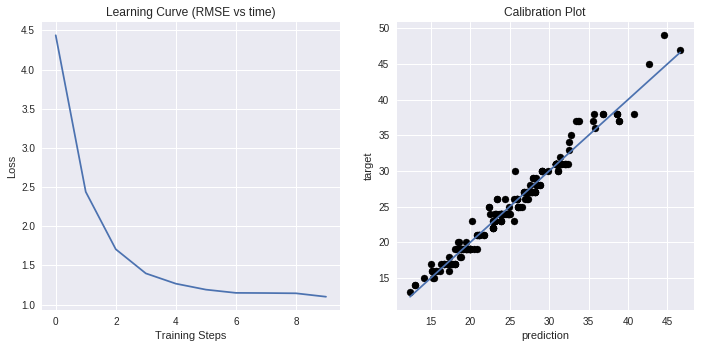

In [68]:
# Redefining NUMERICAL_FEATURES and CATEGORICAL FEATURES just for the
# convenience of having them here.

NUMERICAL_FEATURES = ["horsepower", "highway-mpg", "price",
                      "peak-rpm", "compression-ratio"]
CATEGORICAL_FEATURES = ["fuel-system", "make", "fuel-type",
                        "body-style", "drive-wheels"]
LABEL = "city-mpg"

def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns
  """
  drive_wheels = tf.contrib.layers.sparse_column_with_keys(
      column_name="drive-wheels", keys=["fwd", "rwd", "4wd"])
  make = tf.contrib.layers.sparse_column_with_hash_bucket(
      "make", hash_bucket_size=100)
  price = tf.contrib.layers.real_valued_column("price")
  horsepower = tf.contrib.layers.real_valued_column("horsepower")
  highway_mpg = tf.contrib.layers.real_valued_column("highway-mpg")
  peak_rmp = tf.contrib.layers.real_valued_column("peak-rpm")
  compression_ratio = tf.contrib.layers.real_valued_column("compression-ratio")
  return [drive_wheels, make, price, horsepower, highway_mpg, peak_rmp,compression_ratio]

# Generate the training examples
training_examples = prepare_features(car_data)

LEARNING_RATE = 0.04
BATCH_SIZE = 50
STEPS = 1000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor,
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

In [75]:
print (car_data["fuel-system"].unique()) #we can use it with vocabulary
print (car_data["fuel-type"].unique()) #we can use it with vocabulary
print (car_data["body-style"].unique()) # we can use it with bucketize
print (car_data["make"].unique())

['idi' '2bbl' 'mpfi' 'spdi' '1bbl' '4bbl' 'spfi' 'mfi']
['diesel' 'gas']
['sedan' 'convertible' 'hatchback' 'wagon' 'hardtop']
['mercedes-benz' 'subaru' 'mitsubishi' 'alfa-romero' 'volkswagen' 'bmw'
 'plymouth' 'toyota' 'peugot' 'nissan' 'jaguar' 'volvo' 'renault' 'honda'
 'mazda' 'porsche' 'saab' 'audi' 'dodge' 'isuzu' 'chevrolet' 'mercury']


Training model...
  Loss after period 00 : 2.443
  Loss after period 01 : 1.649
  Loss after period 02 : 1.362
  Loss after period 03 : 1.206
  Loss after period 04 : 1.124
  Loss after period 05 : 1.092
  Loss after period 06 : 1.076
  Loss after period 07 : 1.063
  Loss after period 08 : 1.059
  Loss after period 09 : 1.050
Final Loss (RMSE) on the training data: 1.050


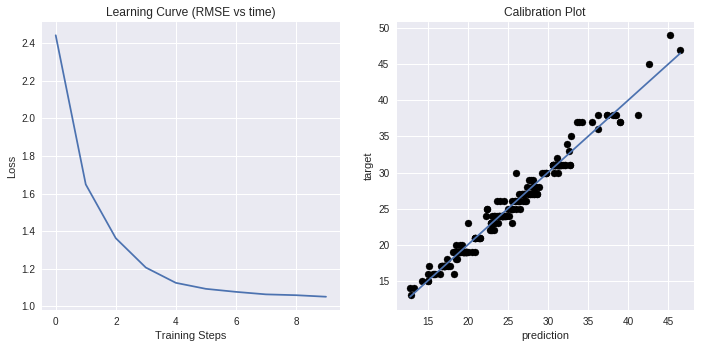

In [83]:
# Redefining NUMERICAL_FEATURES and CATEGORICAL FEATURES just for the
# convenience of having them here.

NUMERICAL_FEATURES = ["horsepower", "highway-mpg", "price",
                      "peak-rpm", "compression-ratio"]
CATEGORICAL_FEATURES = ["fuel-system", "make", "fuel-type",
                        "body-style", "drive-wheels"]
LABEL = "city-mpg"

def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns
  """
  fuel_type = tf.contrib.layers.sparse_column_with_keys(column_name="fuel-type",
  keys=["gas","diesel"])
  fuel_system = tf.contrib.layers.sparse_column_with_keys(column_name="fuel-system",
  keys=["idi", "2bbl", "mpfi", "spdi", "1bbl", "4bbl", "spfi", "mfi"])
  drive_wheels = tf.contrib.layers.sparse_column_with_keys(
      column_name="drive-wheels", keys=["fwd", "rwd", "4wd"])
  make = tf.contrib.layers.sparse_column_with_hash_bucket(
      "make", hash_bucket_size=100)
  body_style = tf.contrib.layers.sparse_column_with_hash_bucket("body-style", hash_bucket_size=50)
  price = tf.contrib.layers.real_valued_column("price")
  horsepower = tf.contrib.layers.real_valued_column("horsepower")
  highway_mpg = tf.contrib.layers.real_valued_column("highway-mpg")
  peak_rmp = tf.contrib.layers.real_valued_column("peak-rpm")
  compression_ratio = tf.contrib.layers.real_valued_column("compression-ratio")
  return [drive_wheels, make, price, horsepower, highway_mpg, peak_rmp,compression_ratio,fuel_type,fuel_system,body_style]

# Generate the training examples
training_examples = prepare_features(car_data)

LEARNING_RATE = 0.015
BATCH_SIZE = 50
STEPS = 5000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor,
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 2.261
  Loss after period 01 : 1.587
  Loss after period 02 : 1.310
  Loss after period 03 : 1.196
  Loss after period 04 : 1.119
  Loss after period 05 : 1.087
  Loss after period 06 : 1.071
  Loss after period 07 : 1.061
  Loss after period 08 : 1.054
  Loss after period 09 : 1.051
Final Loss (RMSE) on the training data: 1.051


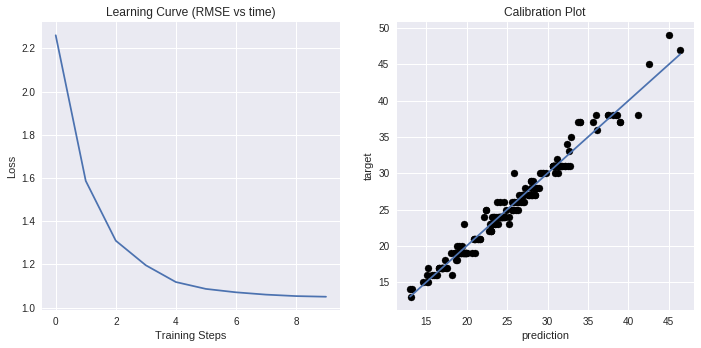

In [88]:
# Redefining NUMERICAL_FEATURES and CATEGORICAL FEATURES just for the
# convenience of having them here.

NUMERICAL_FEATURES = ["horsepower", "highway-mpg", "price",
                      "peak-rpm", "compression-ratio"]
CATEGORICAL_FEATURES = ["fuel-system", "make", "fuel-type",
                        "body-style", "drive-wheels"]
LABEL = "city-mpg"

def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns
  """
  fuel_type = tf.contrib.layers.sparse_column_with_keys(column_name="fuel-type",
  keys=["gas","diesel"])
  fuel_system = tf.contrib.layers.sparse_column_with_keys(column_name="fuel-system",
  keys=["idi", "2bbl", "mpfi", "spdi", "1bbl", "4bbl", "spfi", "mfi"])
  drive_wheels = tf.contrib.layers.sparse_column_with_keys(
      column_name="drive-wheels", keys=["fwd", "rwd", "4wd"])
  make = tf.contrib.layers.sparse_column_with_hash_bucket(
      "make", hash_bucket_size=100)
  body_style = tf.contrib.layers.sparse_column_with_keys(column_name="body-style",
  keys=["sedan",  "convertible", "hatchback", "wagon", "hardtop"])
  price = tf.contrib.layers.real_valued_column("price")
  horsepower = tf.contrib.layers.real_valued_column("horsepower")
  highway_mpg = tf.contrib.layers.real_valued_column("highway-mpg")
  peak_rmp = tf.contrib.layers.real_valued_column("peak-rpm")
  compression_ratio = tf.contrib.layers.real_valued_column("compression-ratio")
  return [drive_wheels, make, price, horsepower, highway_mpg, peak_rmp,compression_ratio,fuel_type,fuel_system,body_style]

# Generate the training examples
training_examples = prepare_features(car_data)

LEARNING_RATE = 0.017
BATCH_SIZE = 50
STEPS = 5000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor,
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 2.163
  Loss after period 01 : 1.445
  Loss after period 02 : 1.206
  Loss after period 03 : 1.124
  Loss after period 04 : 1.085
  Loss after period 05 : 1.073
  Loss after period 06 : 1.053
  Loss after period 07 : 1.055
  Loss after period 08 : 1.052
  Loss after period 09 : 1.046
Final Loss (RMSE) on the training data: 1.046


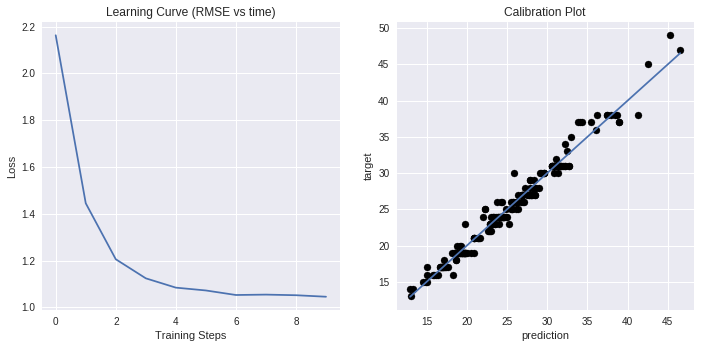

In [104]:
# Redefining NUMERICAL_FEATURES and CATEGORICAL FEATURES just for the
# convenience of having them here.

NUMERICAL_FEATURES = ["horsepower", "highway-mpg", "price",
                      "peak-rpm", "compression-ratio"]
CATEGORICAL_FEATURES = ["fuel-system", "make", "fuel-type",
                        "body-style", "drive-wheels"]
LABEL = "city-mpg"

def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns
  """
  fuel_type = tf.contrib.layers.sparse_column_with_hash_bucket( "fuel-type", hash_bucket_size=50)
  fuel_system = tf.contrib.layers.sparse_column_with_hash_bucket( "fuel-system", hash_bucket_size=50)
  drive_wheels = tf.contrib.layers.sparse_column_with_keys(
      column_name="drive-wheels", keys=["fwd", "rwd", "4wd"])
  make = tf.contrib.layers.sparse_column_with_hash_bucket(
      "make", hash_bucket_size=100)
  body_style = tf.contrib.layers.sparse_column_with_hash_bucket( "body-style", hash_bucket_size=50)
  price = tf.contrib.layers.real_valued_column("price")
  horsepower = tf.contrib.layers.real_valued_column("horsepower")
  highway_mpg = tf.contrib.layers.real_valued_column("highway-mpg")
  peak_rmp = tf.contrib.layers.real_valued_column("peak-rpm")
  compression_ratio = tf.contrib.layers.real_valued_column("compression-ratio")
  return [drive_wheels, make, highway_mpg, peak_rmp,compression_ratio,fuel_type,fuel_system,horsepower,price, body_style] # horsepower, pricebody_style,

# Generate the training examples
training_examples = prepare_features(car_data)

LEARNING_RATE = 0.017
BATCH_SIZE = 50
STEPS = 6000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor,
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Lianne Sánchez Rodríguez 
Process of thought for Lab 5:

We were given an example that only had the features  drive_wheels, make and price this had an RMSE: **4.050**

Step 1. I decided to add one other numerical feature this being horsepower, because the more horsepower the more fuel concumption a car will have [1]. This gave a lower RMSE than the first case **3.321**.

Step 2. I decided to test adding one feature and eliminate horsepower. I added highway-mpg because there is a very close correlation between that and the city-mpg as found in past labs. The RMSE found was much lower than before **1.196**. Knowing this drastic change made me aware that this feature in specific was extremely important inorder to find the prediction of city-mpg.

Step 3. I decided to test and add all the numerical features ["horsepower", "highway-mpg", "price", "peak-rpm", "compression-ratio"]. This because we already prove that horsepower, highway-mpg and price correlate with city-mpg. Well, so does peak-rpm, revolutions per minute  is a measure of how many times the engine turns over in a minute, this affects fuel consumption which affects mpg [2]. I also added compression-ratio because by definition this  is the ratio of the volume of the cylinder and the combustion chamber [3]. By making the compression-ratio bigger then we can improve fuel economy. The RMSE for this model was **1.100**

Step 4,5,6. I thought of adding the ["fuel-system", "make", "fuel-type","body-style", "drive-wheels"] which are my categorical values either with buckets or with vocabulary list because I knew all the values in my training data by using the unique() method. Fuel-type impacts mpg because the higher the octanage level the more economy of fuel you have. Body styles affect mpg also because of the different weight[4]. Also, fuel-system affects how the car consumes the fuel thus correlating to mpg. I have three variations of these because I changed learning rate or steps in order the results where **1.050, 1.051, 1.046**.


My lowest RMSE was when I used all of the features to predict the model and the value was **1.046**. With parameters:

LEARNING_RATE = 0.017

BATCH_SIZE = 50

STEPS = 6000








---




[1] https://www.nrcan.gc.ca/sites/www.nrcan.gc.ca/files/oee/pdf/transportation/fuel-efficient-technologies/autosmart_factsheet_7_e.pdf

[2] https://www.quora.com/Does-RPM-affect-fuel-consumption

[3] https://auto.howstuffworks.com/compression-ratio-fuel-economy.html

[4] https://www.autoblog.com/2009/10/29/greenlings-how-does-weight-affect-a-vehicles-efficiency/